In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
from tqdm import tqdm

from pathlib import Path

models_folder = Path("models")
metadatas_folder = Path("models_metadata")

# Ring distribution

In [16]:
# create a ring distribution class with arguments pis, radiuses, spreads and a sampling method and a prob density method and a log_prob method
dim = 2

class RingMixtureDist():
    def __init__(self,
                 pis : torch.tensor,
                 radiuses : torch.tensor,
                 spreads : torch.tensor):
        self.pis = pis
        self.radiuses = radiuses
        self.spreads = spreads
        self.num_rings = pis.shape[0]

        assert len(pis) == len(radiuses) == len(spreads)
        assert torch.isclose(torch.sum(pis), torch.tensor(1.0), rtol=1e-05, atol=1e-08)

    def sample(self, 
               batch_shape: tuple=(128,)):
        num_samples = batch_shape[0]
        # Step 1: Sample component indices from categorical distribution
        component_dist = torch.distributions.Categorical(self.pis)
        component_samples = component_dist.sample((num_samples,))
        samples = torch.zeros(num_samples, 2)
        # Step 2: Prepare storage for samples
        samples = torch.zeros(num_samples, dim)
        # Step 3: Sample from each ring component
        for i in range(self.num_rings):
            # Mask to select samples for the i-th component
            mask = component_samples == i
            n_samples_i = mask.sum().item()  # Number of samples for component i
            # Only sample if this component was selected at least once
            if n_samples_i > 0:
                # sample a gaussian noise around the radius
                r_samples = self.radiuses[i] * torch.ones(n_samples_i)
                r_samples += torch.normal(mean=0, std=self.spreads[i], size=(n_samples_i,))
                theta_samples = torch.rand(n_samples_i) * (2 * np.pi)  #uniform angle distribution
                # Generate samples for this component and store in the correct positions
                samples[mask, 0] = r_samples * torch.cos(theta_samples)
                samples[mask, 1] = r_samples * torch.sin(theta_samples)
        return samples

    def prob_density(self,
                     positions : torch.tensor):
      assert positions.shape[1] == 2
      density = torch.zeros(positions.shape[0])
      for i in range(self.num_rings):
          normal_dist = torch.distributions.Normal(self.radiuses[i], self.spreads[i])
          positions_norm = torch.norm(positions, p=2, dim=1)
          # Compute the PDF of the i-th component at each grid point
          density += self.pis[i] * torch.exp(normal_dist.log_prob(positions_norm)) / (2*np.pi*positions_norm)
      density /= torch.sum(density)
      return density
    
    def radial_prob_density(self,
                            r):
        density = torch.zeros(r.shape[0])
        for i in range(self.num_rings):
            normal_dist = torch.distributions.Normal(self.radiuses[i], self.spreads[i])
            # Compute the PDF of the i-th component at each grid point
            density += self.pis[i] * torch.exp(normal_dist.log_prob(r)) * r
        density /= torch.sum(density) * (r[1] - r[0])
        return density

    def log_prob(self,
                 positions : torch.tensor,
                 eps : float=1e-12):
      return np.log(self.prob_density(positions) + eps)

In [17]:
ring_config = {
              'n_components':2,
              'n_samples':1000,
              'r1':2,
              'r2':5,
              'spread_1': 0.2,
              'spread_2': 0.2,
               }

pis = torch.tensor([ring_config['r1'], ring_config['r2']]) / (ring_config['r1'] + ring_config['r2'])    # probabilities to be in each component
radiuses = torch.tensor([ring_config['r1'], ring_config['r2']])
spreads = torch.tensor([ring_config['spread_1'], ring_config['spread_2']])

two_rings_mixture = RingMixtureDist(pis, radiuses, spreads)  #ring mixture object
samples = two_rings_mixture.sample((ring_config['n_samples'],))


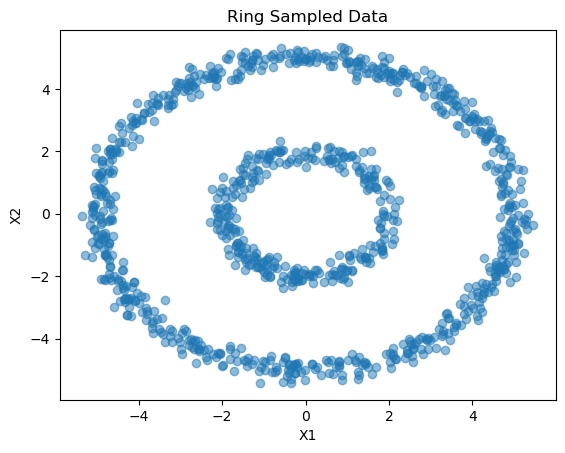

In [18]:
plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), alpha=0.5)
plt.title("Ring Sampled Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

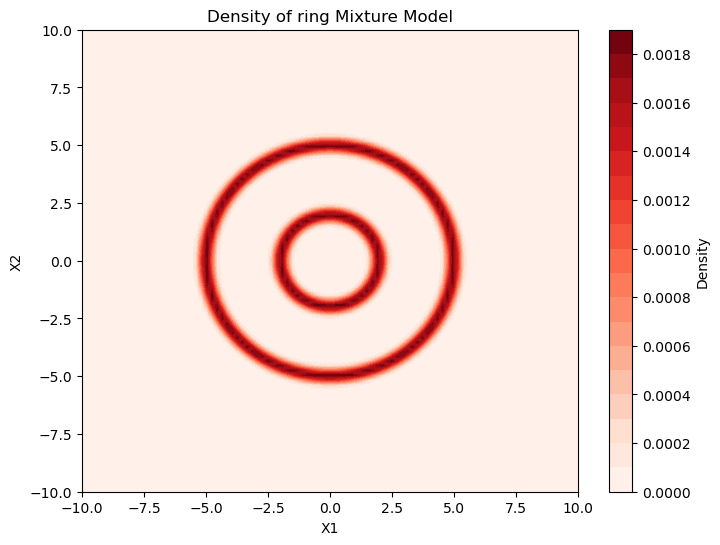

In [19]:
# Generate a grid of points
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

density = two_rings_mixture.prob_density(positions_tensor)
# Reshape the density to match the grid shape
density = density.numpy().reshape(X.shape)

# Plot the density contours
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, density, levels=20, cmap="Reds")
plt.colorbar(label="Density")
plt.title("Density of ring Mixture Model")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Score matching tools

In [20]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

In [21]:
#denoising score matching tools
def dsm(energy_net, samples, sigma=1):
    samples.requires_grad_(True)
    vector = torch.randn_like(samples) * sigma
    perturbed_inputs = samples + vector
    logp = -energy_net(perturbed_inputs)
    dlogp = sigma ** 2 * autograd.grad(logp.sum(), perturbed_inputs, create_graph=True)[0]
    kernel = vector
    loss = torch.norm(dlogp + kernel, dim=-1) ** 2
    loss = loss.mean() / 2.

    return loss


def dsm_score_estimation(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)

    return loss


def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    return loss.mean(dim=0)

In [22]:
class ConditionalInstanceNorm1dPlus(nn.Module):
    """
    Conditional instance normalization layer as described in 
    "Generative Modeling by Estimating Gradients of the
    Data Distribution" (2019) by Yang Song and Stefano Ermon
    """
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 3)
            self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, 2 * num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, 2 * num_features)
            self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, labels):
        mus = torch.mean(x, dim=0)
        m = torch.mean(mus, dim=-1, keepdim=True)
        v = torch.var(mus, dim=-1, keepdim=True)
        means = (mus - m) / (torch.sqrt(v + 1e-5))
        h = (x - mus) / torch.std(x, dim=1, keepdim=True)
        if self.bias:
            gamma, bias, alpha = self.embed(labels).chunk(3, dim=-1)
            out = gamma * h + bias + alpha * (mus - m) / v
        else:
            gamma, alpha = self.embed(labels).chunk(2, dim=-1)
            out = gamma * h + bias + alpha * (mus - m) / v
        return out

class ToyAnnealedScoreNet(nn.Module):
    """
    Noise Conditional Score Network (NCSN) implementation 
    for 2D toy examples
    """
    def __init__(self, num_classes: int, add_layer=False):
        super().__init__()
        hidden_units = 128
        self.add_layer = add_layer
        self.layer1 = nn.Sequential(nn.Linear(2, hidden_units), nn.Softplus())
        self.conditional_gains1 = ConditionalInstanceNorm1dPlus(hidden_units, num_classes, bias=True)
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units), nn.Softplus()
        )
        self.conditional_gains2 = ConditionalInstanceNorm1dPlus(hidden_units, num_classes, bias=True)
        self.layer3 = nn.Linear(hidden_units, 2)

    def forward(self, x, labels):
        h = self.layer1(x)
        h = self.conditional_gains1(h, labels)
        h = self.layer2(h)
        h = self.conditional_gains2(h, labels)
        out = self.layer3(h)
        return out
    
class ToyAnnealedScoreNetBis(nn.Module):
    """
    Noise Conditional Score Network (NCSN) implementation 
    for 2D toy examples
    Increased model's capacity compared to ToyAnnealedScoreNet
    by adding one layer
    """
    def __init__(self, num_classes: int, add_layer=False):
        super().__init__()
        hidden_units = 128
        self.add_layer = add_layer
        self.layer1 = nn.Sequential(nn.Linear(2, hidden_units), nn.Softplus())
        self.conditional_gains1 = ConditionalInstanceNorm1dPlus(hidden_units, num_classes, bias=True)
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units), nn.Softplus()
        )
        self.conditional_gains2 = ConditionalInstanceNorm1dPlus(hidden_units, num_classes, bias=True)
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units), nn.Softplus()
        )
        self.conditional_gains3 = ConditionalInstanceNorm1dPlus(hidden_units, num_classes, bias=True)
        self.final_layer = nn.Linear(hidden_units, 2)

    def forward(self, x, labels):
        h = self.layer1(x)
        h = self.conditional_gains1(h, labels)
        h = self.layer2(h)
        h = self.conditional_gains2(h, labels)
        h = self.layer3(h)
        h = self.conditional_gains3(h, labels)
        out = self.final_layer(h)
        return out

In [ ]:
def langevin_dynamics(score, init, lr=0.1, step=1000):
    """
    Performs Langevin dynamics simulation to sample from a probability distribution
    from a simple score network.
    """
    for i in range(step):
        current_lr = lr
        init = init + current_lr / 2 * score(init).detach()
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def anneal_langevin_dynamics(score, init, sigmas, lr=0.1, n_steps_each=100, langevin_noise=True):
    """
    Performs annealed Langevin dynamics simulation to sample from a probability distribution
    from a noise conditioned score network.

    Parameters:
        score (callable): The score function that computes the gradient of the log-probability density.
        init (Tensor): The initial points for the simulation.
        sigmas (list of float): A list of noise schedules for the annealing process (must match score's noise schedule).
        lr (float, optional): The learning rate for the simulation. Defaults to 0.1.
        n_steps_each (int, optional): The number of steps to run the simulation for each noise schedule. Defaults to 100.
        langevin_noise (bool, optional): Whether to add Langevin noise to the simulation. Defaults to True.

    Returns:
        Tensor: The final points sampled from the probability distribution.
    """
    for i, sigma in enumerate(sigmas):
        for _ in range(n_steps_each):
            current_lr = lr * (sigma / sigmas[-1]) ** 2
            init = init + current_lr / 2 * score(init, torch.tensor([i]).int()).detach()
            if langevin_noise:
                init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def anneal_langevin_dynamics_inter(score, init, sigmas, lr=0.1, n_steps_each=100, langevin_noise=True):
    """
    Performs annealed Langevin dynamics simulation to sample from a probability distribution
    returning all intermediate noise samples.
    """
    intermediates = [init.detach().numpy()]
    for i, sigma in enumerate(sigmas):
        for _ in range(n_steps_each):
            current_lr = lr * (sigma / sigmas[-1]) ** 2
            init = init + current_lr / 2 * score(init, torch.tensor([i]).int()).detach()
            if langevin_noise:
                init = init + torch.randn_like(init) * np.sqrt(current_lr)
        intermediates.append(init.detach().numpy())
    return intermediates

#def hamilton_dynamics(grad_f, initial_x, num_samples=1000, step_size=0.1, num_steps=20):
#    """
#    Hamiltonian dynamics using leapfrog integration.
#
#    Parameters:
#        grad_f (function): Gradient of the negative log-probability (potential energy).
#                torch neural network, should be fed with torch.tensor
#        initial_x (np.ndarray): Initial position in parameter space.
#        num_samples (int): Number of samples to draw.
#        step_size (float): Leapfrog step size (epsilon).
#        num_steps (int): Number of leapfrog steps (L).
#
#    Returns:
#        samples (np.ndarray): Collected samples from the target distribution.
#    """
#    # Initialize parameters
#    initial_x = torch.tensor(initial_x, dtype=torch.float32).view(1, -1)
#    dim = initial_x.shape[1]
#    samples = []
#    
#    for _i in range(num_samples):
#        # Step 1: Sample momentum
#        initial_p = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim))
#        # Step 2: Simulate Hamiltonian dynamics using leapfrog
#        x_new, p_new = initial_x, torch.tensor(initial_p, dtype=torch.float32).view(1, -1)
#        initial_p = torch.tensor(np.zeros(dim), dtype=torch.float32).view(1, -1)
#        x_new, p_new = initial_x, initial_p
#        for _j in range(num_steps):
#            p_new -= 0.5 * step_size * grad_f(x_new)  # Half-step momentum update
#            x_new += step_size * p_new  # Full-step position update
#            p_new -= 0.5 * step_size * grad_f(x_new)  # Final half-step momentum update
#            #print(x_new[0].detach().numpy())
#        # Step 3: Save the new state
#        initial_x = x_new
#        samples.append(initial_x[0].detach().numpy())
#
#    return np.array(samples)

## Monoring case

In [24]:
monoring_config = {
              'n_components':1,
              'r1':5,
              'spread_1': 0.2,
               }

### Monoring train

In [26]:
prev_n_epochs = 10002
n_epochs = 10002
batch_size = 1024
add_layer = True

#if start from scratch
num_classes = 10
sigma_begin = 2
sigma_end = 0.1

model_path = models_folder / f"score_mono{monoring_config['r1']}_b{batch_size}_e{prev_n_epochs}_s{num_classes}.pth"
metadata_path = metadatas_folder / f"score_mono{monoring_config['r1']}_b{batch_size}_e{prev_n_epochs}_s{num_classes}.json"

In [27]:
import json

if prev_n_epochs > 0:
    #if load old model
    with open(metadata_path, "r") as file:
        metadata = json.load(file)

    losses = metadata['losses']
    sigmas = torch.tensor(metadata['sigmas'])
    # Load state dictionary
    if add_layer:
        score = ToyAnnealedScoreNetBis(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
    else:
        score = ToyAnnealedScoreNet(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
    score.load_state_dict(torch.load(model_path))

else:
    #if start from scratch
    losses = []
    sigmas = torch.tensor(
        np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end),
                            num_classes))).float()
    if add_layer:
        score = ToyAnnealedScoreNetBis(num_classes=num_classes, add_layer=add_layer)
    else:
        score = ToyAnnealedScoreNet(num_classes=num_classes, add_layer=add_layer)

In [28]:
pis = torch.tensor([1.])   # probabilities to be in each component
radiuses = torch.tensor([monoring_config['r1']])
spreads = torch.tensor([monoring_config['spread_1']])

teacher = RingMixtureDist(pis, radiuses, spreads)
optimizer = optim.Adam(score.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
score = score.to(device)

for step in tqdm(range(prev_n_epochs, n_epochs)):
    samples = teacher.sample((batch_size,)).to(device)
    labels = torch.randint(0, len(sigmas), (samples.shape[0],)).to(device)

    loss = anneal_dsm_score_estimation(score, samples, labels, sigmas)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print('step: {}, loss: {}'.format(step, loss.item()))

metadata_path = f"score_mono{monoring_config['r1']}_b{batch_size}_e{n_epochs}_s{num_classes}.json"
model_path = f"score_mono{monoring_config['r1']}_b{batch_size}_e{n_epochs}_s{num_classes}.pth"

dict_to_save = {
    "losses" : losses,
    "sigmas" : sigmas.tolist(),
    "n_epochs" : n_epochs,
}
with open(metadata_path, "w") as file:
    json.dump(dict_to_save, file)

torch.save(score.state_dict(), model_path)

0it [00:00, ?it/s]

### Monoring results

In [30]:
# Load state dictionary
n_epochs = 10001
batch_size = 1024
add_layer = True
num_classes = 10

model_path = models_folder / f"score_mono{monoring_config['r1']}_b{batch_size}_e{n_epochs}_s{num_classes}.pth"
metadata_path = metadatas_folder / f"score_mono{monoring_config['r1']}_b{batch_size}_e{n_epochs}_s{num_classes}.json"

if add_layer:
    score = ToyAnnealedScoreNetBis(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
else:
    score = ToyAnnealedScoreNet(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
score.load_state_dict(torch.load(model_path))
score.eval()  # Set to evaluation mode

with open(metadata_path, "r") as file:
    metadata = json.load(file)

losses = metadata['losses']
sigmas = torch.tensor(metadata['sigmas'])

pis = torch.tensor([1.])   # probabilities to be in each component
radiuses = torch.tensor([monoring_config['r1']])
spreads = torch.tensor([monoring_config['spread_1']])

teacher = RingMixtureDist(pis, radiuses, spreads)

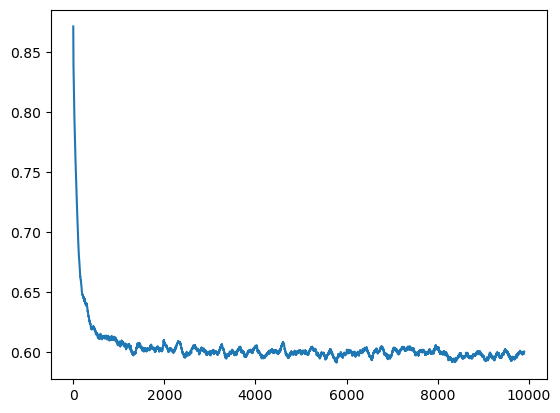

In [31]:
plt.plot(np.convolve(losses, np.ones(100) / 100, mode='valid'));

In [32]:
left_bound = -10
right_bound = 10

samples = torch.rand(500, 2) * (right_bound - left_bound) + left_bound
intermediates_langevin_noise = anneal_langevin_dynamics_inter(score, 
                                        samples, sigmas, lr=2e-4, n_steps_each=400, langevin_noise=True)
intermediates_no_langevin_noise = anneal_langevin_dynamics_inter(score, 
                                        samples, sigmas, lr=1e-2, n_steps_each=5, langevin_noise=False)
s_langevin_noise = intermediates_langevin_noise[-1]
s_no_langevin_noise = intermediates_no_langevin_noise[-1]

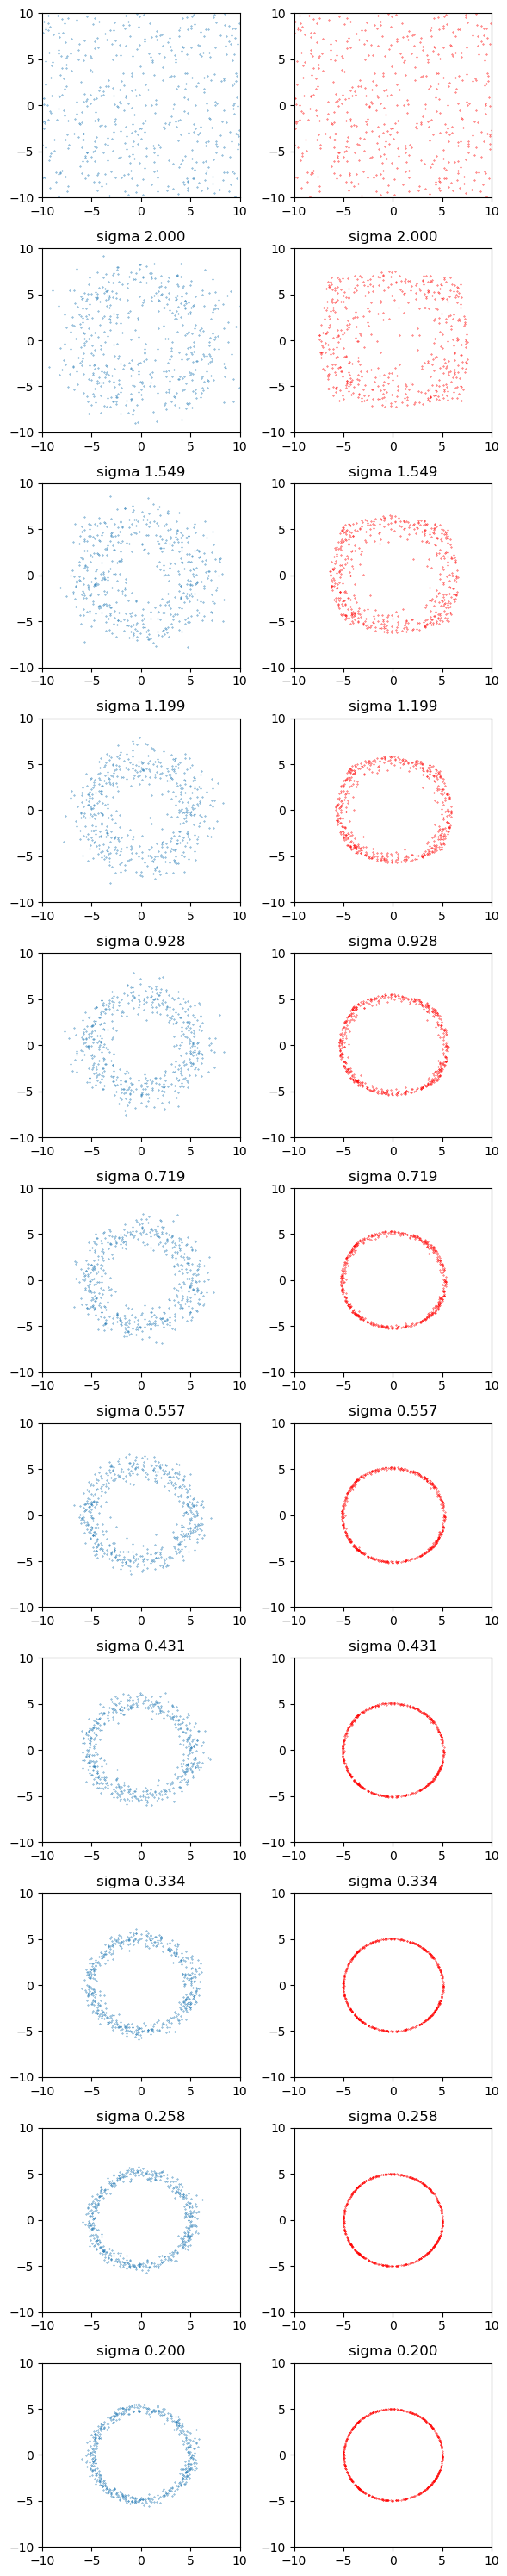

In [33]:
fig, ax = plt.subplots(num_classes + 1, 2, figsize=(6, 12* num_classes / 4))

for i in range(num_classes + 1):
    ax[i, 0].scatter(intermediates_langevin_noise[i][:, 0], intermediates_langevin_noise[i][:, 1], s=0.1)
    ax[i, 0].set_xlim([left_bound, right_bound])
    ax[i, 0].set_ylim([left_bound, right_bound])
    ax[i, 1].scatter(intermediates_no_langevin_noise[i][:, 0], intermediates_no_langevin_noise[i][:, 1],c='r', s=0.1)
    ax[i, 1].set_xlim([left_bound, right_bound])
    ax[i, 1].set_ylim([left_bound, right_bound])
    if i > 0:
        ax[i, 0].set_title(f"sigma {sigmas[i- 1]:.3f}")
        ax[i, 1].set_title(f"sigma {sigmas[i - 1]:.3f}")
plt.tight_layout()

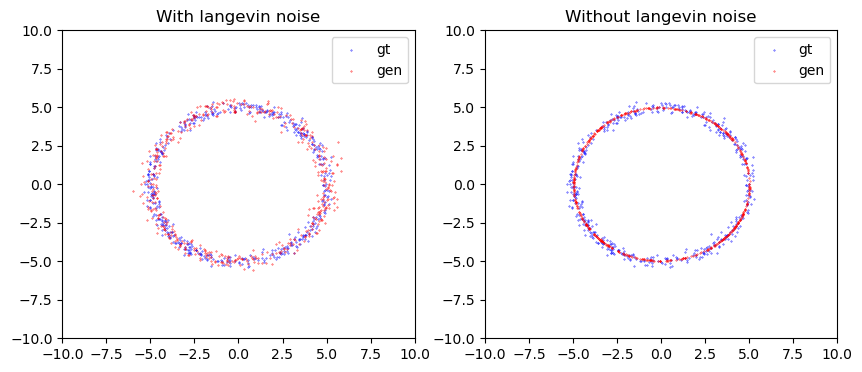

In [34]:
samples = teacher.sample((500,))
samples = samples.detach().cpu().numpy()
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].scatter(samples[:, 0], samples[:, 1],c="b", s=0.1, label='gt')
ax[0].scatter(s_langevin_noise[:,0], s_langevin_noise[:,1], c="r", s=0.1, label='gen')
ax[0].set_title("With langevin noise")
ax[1].scatter(samples[:, 0], samples[:, 1],c="b", s=0.1, label='gt')
ax[1].scatter(s_no_langevin_noise[:,0], s_no_langevin_noise[:,1], c="r", s=0.1, label='gen')
ax[1].set_title("Without langevin noise")
ax[0].legend()
ax[1].legend()
left_bound = -10
right_bound = 10
ax[0].set_xlim([left_bound, right_bound])
ax[0].set_ylim([left_bound, right_bound])
ax[1].set_xlim([left_bound, right_bound])
ax[1].set_ylim([left_bound, right_bound]);

In [35]:
out_of_frame = 0
for elem in s_langevin_noise:
  if elem[0] > 10 or elem[0] < -10 or elem[1] > 10 or elem[1] < -10:
    out_of_frame +=1
print("out of frame with noise", out_of_frame)
out_of_frame = 0
for elem in s_no_langevin_noise:
  if elem[0] > 10 or elem[0] < -10 or elem[1] > 10 or elem[1] < -10:
    out_of_frame +=1
print("out_of_frame without noise", out_of_frame)

out of frame with noise 0
out_of_frame without noise 0


Text(0.5, 1.0, 'Radius distrib Without langevin noise')

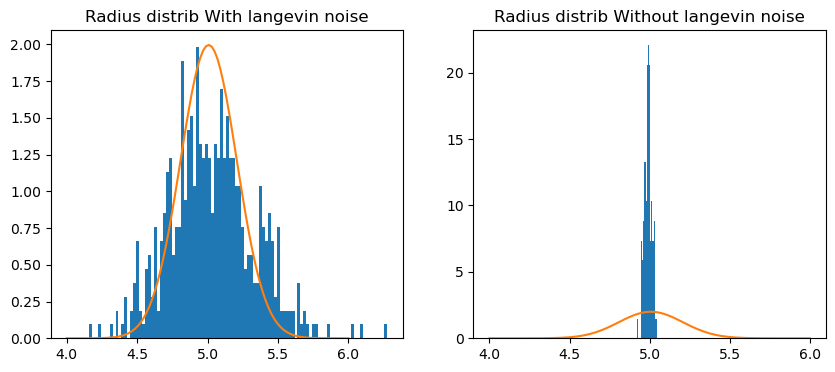

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
norms = np.sqrt(s_langevin_noise[:,0]**2 + s_langevin_noise[:,1]**2)
ax[0].hist(norms, bins=100, density=True)
r = np.linspace(4, 6, 100)
ax[0].plot(r, teacher.radial_prob_density(torch.tensor(r)))
ax[0].set_title("Radius distrib With langevin noise")

norms = np.sqrt(s_no_langevin_noise[:,0]**2 + s_no_langevin_noise[:,1]**2)
ax[1].hist(norms, bins=100, density=True)
ax[1].plot(r, teacher.radial_prob_density(torch.tensor(r)))
ax[1].set_title("Radius distrib Without langevin noise")

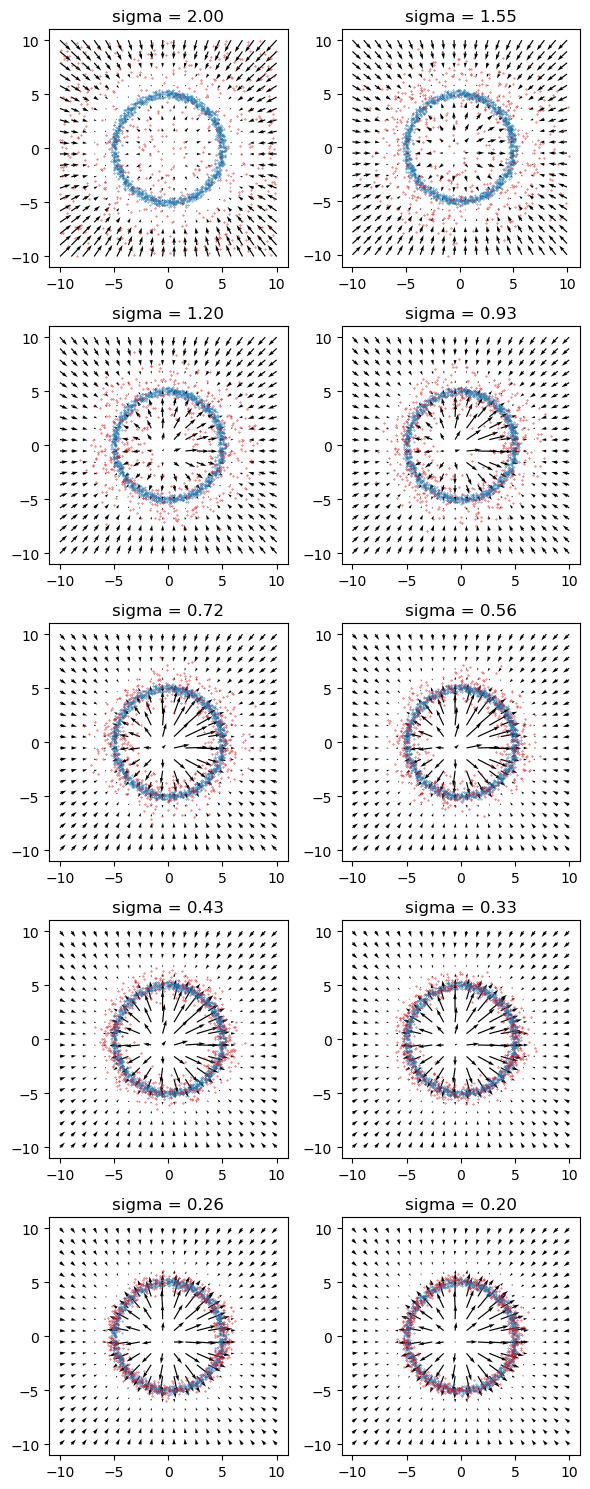

In [37]:
mesh = []
grid_size = 100
left_bound=-10
right_bound=10
x = np.linspace(left_bound, right_bound, grid_size)
y = np.linspace(left_bound, right_bound, grid_size)
for i in x:
    for j in y:
        mesh.append(np.asarray([i, j]))

mesh = np.stack(mesh, axis=0)
mesh = torch.from_numpy(mesh).float()

grid_size = 20
mesh = []
x = np.linspace(left_bound, right_bound, grid_size)
y = np.linspace(left_bound, right_bound, grid_size)
for i in x:
    for j in y:
        mesh.append(np.asarray([i, j]))
mesh = np.stack(mesh, axis=0)

samples = teacher.sample((1280,))
samples = samples.detach().cpu().numpy()

fig, ax = plt.subplots(int(num_classes // 2) ,2, figsize=(6, 6* num_classes / 4))
for i in range(num_classes):
  mesh = torch.from_numpy(mesh).float()
  scores = score(mesh.detach(), torch.Tensor([i]).int())
  mesh = mesh.detach().numpy()
  scores = scores.detach().numpy()

  ax[i//2, i%2].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
  ax[i//2, i%2].set_title(f"sigma = {sigmas[i]:.2f}")

  ax[i//2, i%2].scatter(samples[:, 0], samples[:, 1], s=0.1, label="real _distrib")
  ax[i//2, i%2].scatter(intermediates_langevin_noise[i][:, 0], intermediates_langevin_noise[i][:, 1],c="r", s=0.1, label="algo _distrib")
  #ax[i//2, i%2].legend()
plt.tight_layout()

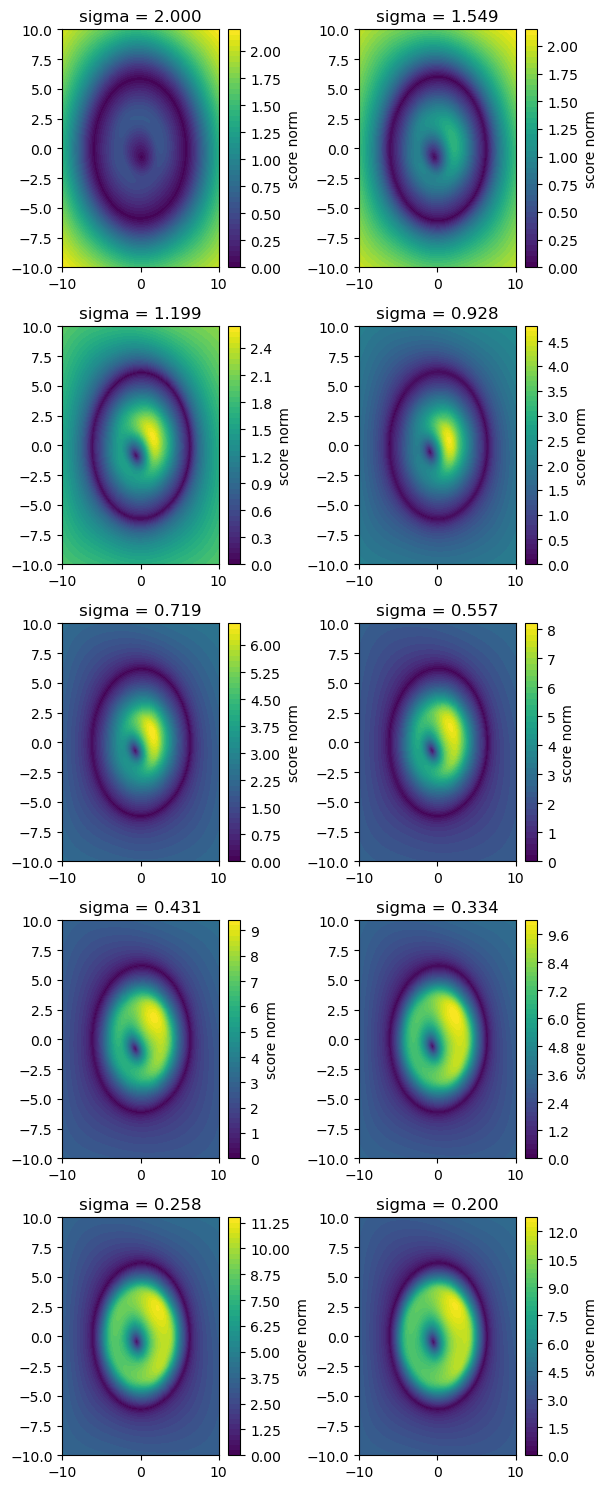

In [38]:
# voir plus précisément que score map (mais perd direction)
ring_mixture = RingMixtureDist(torch.tensor([1.]), torch.tensor([2]), torch.tensor([0.1]))  #ring mixture object

# Generate a finer grid for smoother density visualization
gridsize = 200
grid_lims = 10
x = np.linspace(-grid_lims, grid_lims, gridsize)  # Increased points for smoother plot
y = np.linspace(-grid_lims, grid_lims, gridsize)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

density = ring_mixture.prob_density(positions_tensor)
density = density.numpy().reshape(X.shape)


samples = teacher.sample((1280,))
samples = samples.detach().cpu().numpy()

fig, ax = plt.subplots(int(num_classes // 2) ,2, figsize=(6, 6* num_classes / 4))
for i in range(num_classes):
  scores_map = score(positions_tensor.detach(), torch.Tensor([i]).int())
  scores_map = scores_map.norm(p=2,dim=-1).detach().numpy().reshape(X.shape)

  im2 = ax[i//2, i%2].contourf(X, Y, scores_map, levels=50, cmap="viridis")
  fig.colorbar(im2, ax=ax[i//2, i%2], label="score norm") # Corrected colorbar placement
  ax[i//2, i%2].set_title(f"sigma = {sigmas[i]:.3f}")
plt.tight_layout()  

## Two rings case

In [39]:
prev_n_epochs = 20002
batch_size = 1024
n_epochs = 20002
add_layer = True
#if start from scratch
num_classes = 10
sigma_begin = 2
sigma_end = 0.1

model_path = models_folder / f"score_b{batch_size}_e{prev_n_epochs}_s{num_classes}.pth"
metadata_path = metadatas_folder / f"score_b{batch_size}_e{prev_n_epochs}_s{num_classes}.json"

### Two rings train

In [40]:
import json

if prev_n_epochs > 0:
    #if load old model
    with open(metadata_path, "r") as file:
        metadata = json.load(file)

    losses = metadata['losses']
    sigmas = torch.tensor(metadata['sigmas'])
    # Load state dictionary
    if add_layer:
        score = ToyAnnealedScoreNetBis(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
    else:
        score = ToyAnnealedScoreNet(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
    score.load_state_dict(torch.load(model_path))

else:
    #if start from scratch
    losses = []
    sigmas = torch.tensor(
        np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end),
                            num_classes))).float()
    if add_layer:
        score = ToyAnnealedScoreNetBis(num_classes=num_classes, add_layer=add_layer)
    else:
        score = ToyAnnealedScoreNet(num_classes=num_classes, add_layer=add_layer)

In [41]:
pis = torch.tensor([ring_config['r1'], ring_config['r2']]) / (ring_config['r1'] + ring_config['r2'])    # probabilities to be in each component
radiuses = torch.tensor([ring_config['r1'], ring_config['r2']])
spreads = torch.tensor([ring_config['spread_1'], ring_config['spread_2']])

teacher = RingMixtureDist(pis, radiuses, spreads)
optimizer = optim.Adam(score.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
score = score.to(device)

for step in tqdm(range(prev_n_epochs, n_epochs)):
    samples = teacher.sample((batch_size,)).to(device)
    labels = torch.randint(0, len(sigmas), (samples.shape[0],)).to(device)

    loss = anneal_dsm_score_estimation(score, samples, labels, sigmas)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print('step: {}, loss: {}'.format(step, loss.item()))

metadata_path = f"score_b{batch_size}_e{n_epochs}_s{num_classes}.json"
model_path = f"score_b{batch_size}_e{n_epochs}_s{num_classes}.pth"

dict_to_save = {
    "losses" : losses,
    "sigmas" : sigmas.tolist(),
    "n_epochs" : n_epochs,
}
with open(metadata_path, "w") as file:
    json.dump(dict_to_save, file)

torch.save(score.state_dict(), model_path)

0it [00:00, ?it/s]

### Two rings results

In [42]:
# Load state dictionary
n_epochs = 20002
batch_size = 1024
add_layer = True
num_classes = 10

model_path = models_folder / f"score_b{batch_size}_e{n_epochs}_s{num_classes}.pth"
metadata_path = metadatas_folder / f"score_b{batch_size}_e{n_epochs}_s{num_classes}.json"

if add_layer:
    score = ToyAnnealedScoreNetBis(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
else:
    score = ToyAnnealedScoreNet(num_classes=num_classes, add_layer=add_layer)  # Create a new instance of the model
score.load_state_dict(torch.load(model_path))
score.eval()  # Set to evaluation mode

with open(metadata_path, "r") as file:
    metadata = json.load(file)

losses = metadata['losses']
sigmas = torch.tensor(metadata['sigmas'])

pis = torch.tensor([ring_config['r1'], ring_config['r2']]) / (ring_config['r1'] + ring_config['r2'])    # probabilities to be in each component
radiuses = torch.tensor([ring_config['r1'], ring_config['r2']])
spreads = torch.tensor([ring_config['spread_1'], ring_config['spread_2']])

teacher = RingMixtureDist(pis, radiuses, spreads)

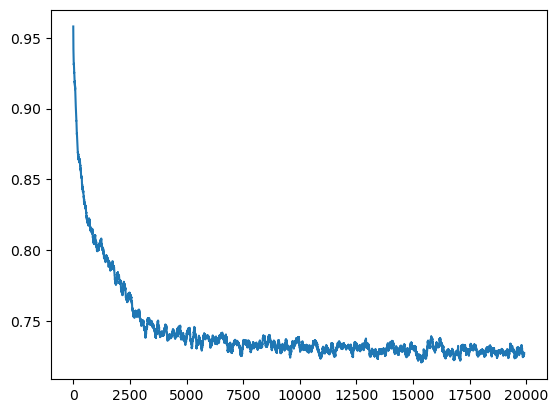

In [43]:
plt.plot(np.convolve(losses, np.ones(100) / 100, mode='valid'));

In [44]:
left_bound = -10
right_bound = 10

samples = torch.rand(500, 2) * (right_bound - left_bound) + left_bound
intermediates_langevin_noise = anneal_langevin_dynamics_inter(score, 
                                        samples, sigmas, lr=1e-4, n_steps_each=300, langevin_noise=True)
intermediates_no_langevin_noise = anneal_langevin_dynamics_inter(score, 
                                        samples, sigmas, lr=1e-3, n_steps_each=8, langevin_noise=False)
s_langevin_noise = intermediates_langevin_noise[-1]
s_no_langevin_noise = intermediates_no_langevin_noise[-1]

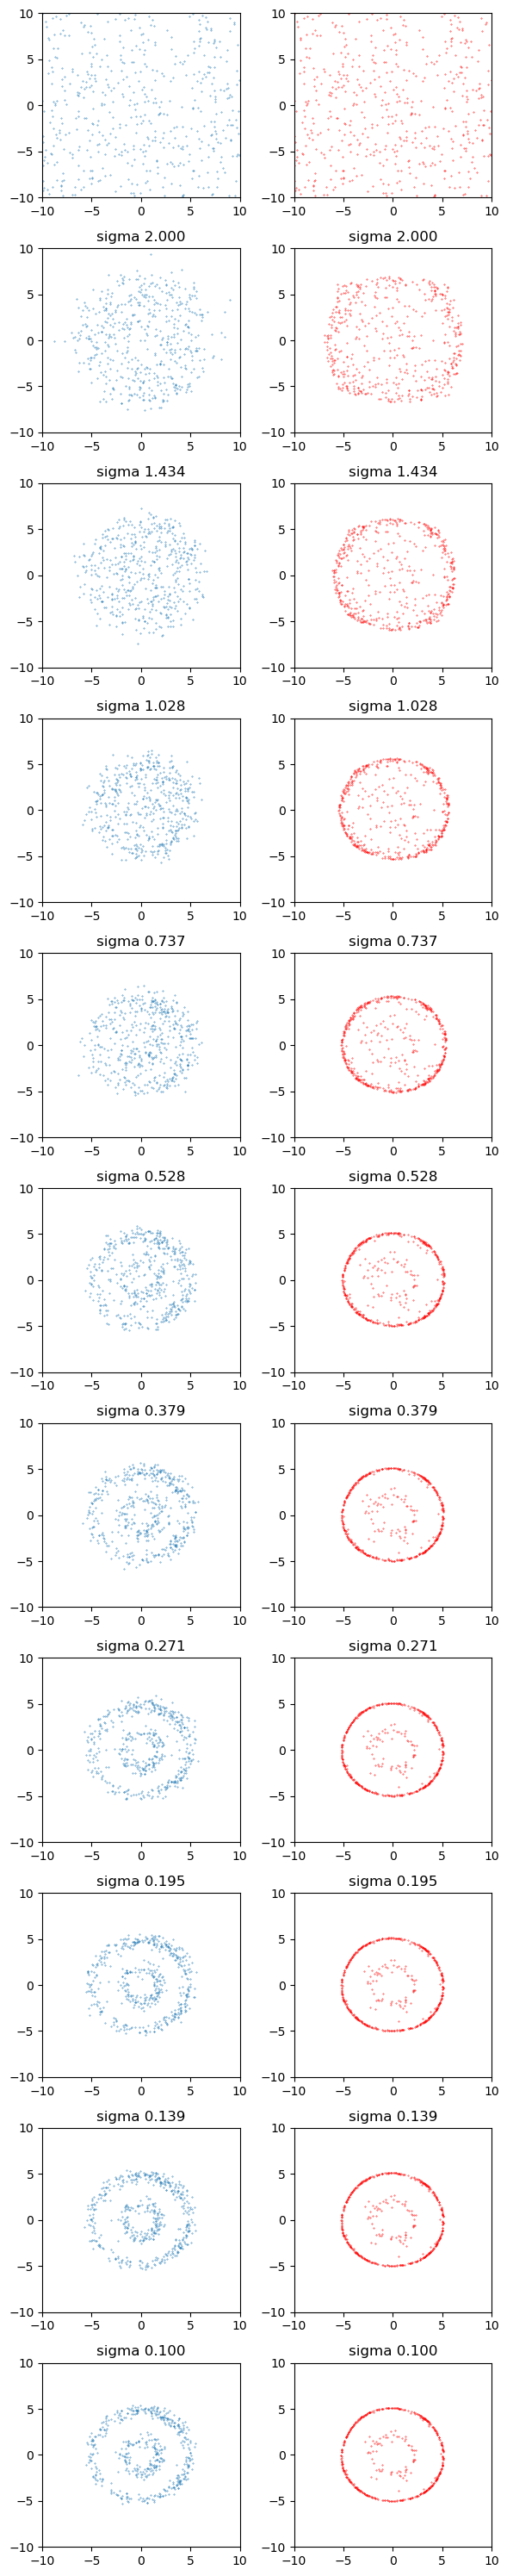

In [45]:
fig, ax = plt.subplots(num_classes + 1, 2, figsize=(6, 12 * num_classes / 4))

for i in range(num_classes + 1):
    ax[i, 0].scatter(intermediates_langevin_noise[i][:, 0], intermediates_langevin_noise[i][:, 1], s=0.1)
    ax[i, 0].set_xlim([left_bound, right_bound])
    ax[i, 0].set_ylim([left_bound, right_bound])
    ax[i, 1].scatter(intermediates_no_langevin_noise[i][:, 0], intermediates_no_langevin_noise[i][:, 1],c='r', s=0.1)
    ax[i, 1].set_xlim([left_bound, right_bound])
    ax[i, 1].set_ylim([left_bound, right_bound])
    if i > 0:
        ax[i, 0].set_title(f"sigma {sigmas[i- 1]:.3f}")
        ax[i, 1].set_title(f"sigma {sigmas[i - 1]:.3f}")
plt.tight_layout()


real repartition tensor([0.2857, 0.7143])
With langevin noise
500
0.298
0.702
Without langevin noise
500
0.138
0.862


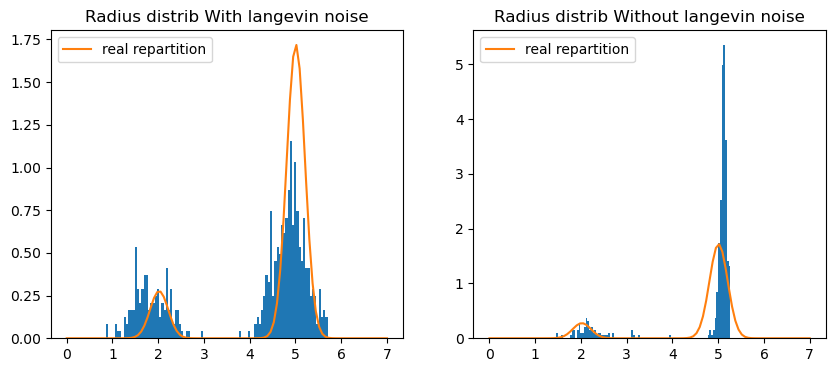

In [47]:
print("real repartition", pis)

fig, ax = plt.subplots(1,2, figsize=(10, 4))
norms = np.sqrt(s_langevin_noise[:,0]**2 + s_langevin_noise[:,1]**2)
print("With langevin noise")
print((norms<7).sum())
print(((norms<3.5)).sum() / (norms<7).sum())
print(((norms>=3.5) & (norms<7)).sum() / (norms<7).sum())

ax[0].hist(norms, bins=100, density=True)
r = np.linspace(0, 7, 100)
ax[0].plot(r, teacher.radial_prob_density(torch.tensor(r)), label="real repartition")
ax[0].legend()
ax[0].set_title("Radius distrib With langevin noise")

norms = np.sqrt(s_no_langevin_noise[:,0]**2 + s_no_langevin_noise[:,1]**2)
print("Without langevin noise")
print((norms<7).sum())
print(((norms<3.5)).sum() / (norms<7).sum())
print(((norms>=3.5) & (norms<7)).sum() / (norms<7).sum())
ax[1].hist(norms, bins=100, density=True)
ax[1].plot(r, teacher.radial_prob_density(torch.tensor(r)), label="real repartition")
ax[1].legend()
ax[1].set_title("Radius distrib Without langevin noise");

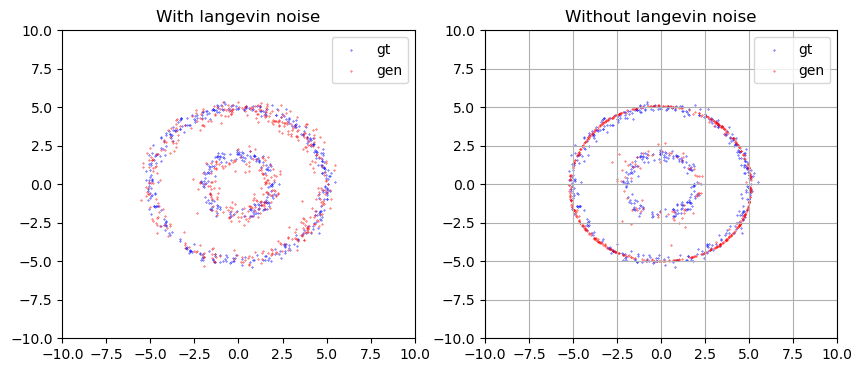

In [48]:
samples = teacher.sample((500,))
samples = samples.detach().cpu().numpy()
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].scatter(samples[:, 0], samples[:, 1],c="b", s=0.1, label='gt')
ax[0].scatter(s_langevin_noise[:,0], s_langevin_noise[:,1], c="r", s=0.1, label='gen')
ax[0].set_title("With langevin noise")
ax[1].scatter(samples[:, 0], samples[:, 1],c="b", s=0.1, label='gt')
ax[1].scatter(s_no_langevin_noise[:,0], s_no_langevin_noise[:,1], c="r", s=0.1, label='gen')
ax[1].set_title("Without langevin noise")
ax[0].legend()
ax[1].legend()
left_bound = -10
right_bound = 10
ax[0].set_xlim([left_bound, right_bound])
ax[0].set_ylim([left_bound, right_bound])
ax[1].set_xlim([left_bound, right_bound])
ax[1].set_ylim([left_bound, right_bound])
ax[1].grid();

In [49]:
out_of_frame = 0
for elem in s_langevin_noise:
  if elem[0] > 10 or elem[0] < -10 or elem[1] > 10 or elem[1] < -10:
    out_of_frame +=1
print("out of frame with noise", out_of_frame)
out_of_frame = 0
for elem in s_no_langevin_noise:
  if elem[0] > 10 or elem[0] < -10 or elem[1] > 10 or elem[1] < -10:
    out_of_frame +=1
print("out_of_frame without noise", out_of_frame)

out of frame with noise 0
out_of_frame without noise 0


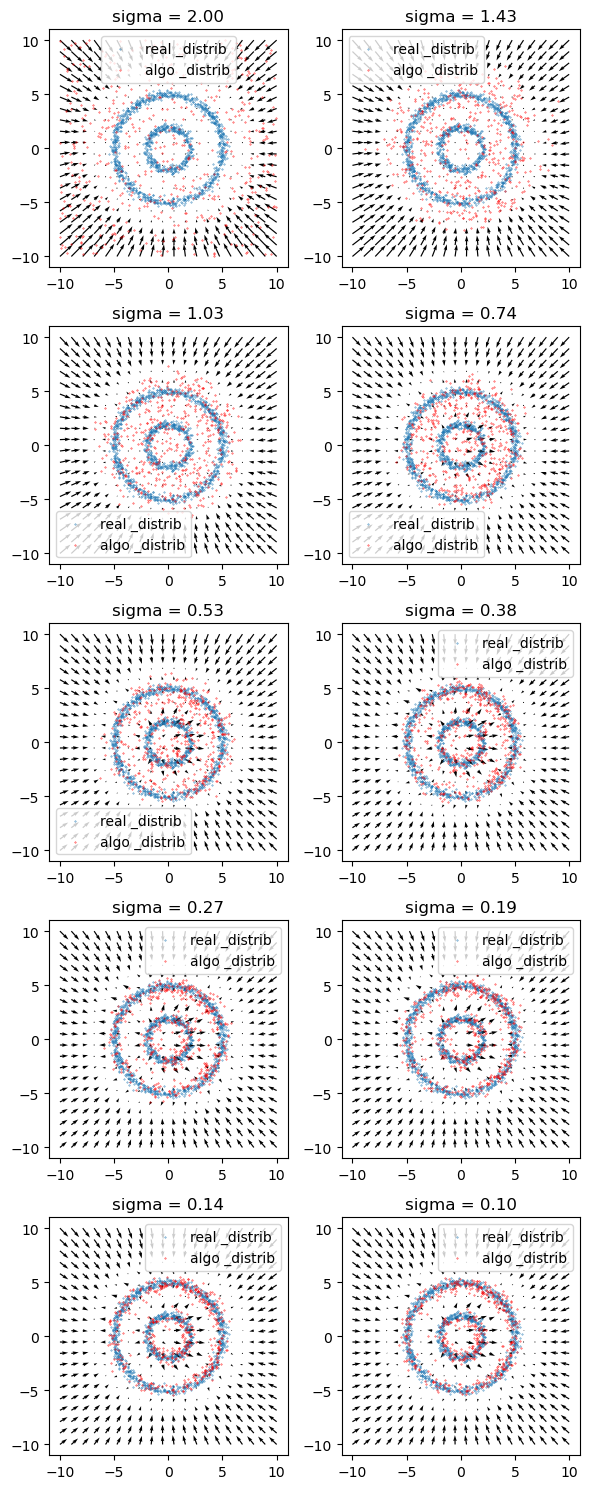

In [50]:
mesh = []
grid_size = 100
left_bound=-10
right_bound=10
x = np.linspace(left_bound, right_bound, grid_size)
y = np.linspace(left_bound, right_bound, grid_size)
for i in x:
    for j in y:
        mesh.append(np.asarray([i, j]))

mesh = np.stack(mesh, axis=0)
mesh = torch.from_numpy(mesh).float()

grid_size = 20
mesh = []
x = np.linspace(left_bound, right_bound, grid_size)
y = np.linspace(left_bound, right_bound, grid_size)
for i in x:
    for j in y:
        mesh.append(np.asarray([i, j]))
mesh = np.stack(mesh, axis=0)

samples = teacher.sample((1280,))
samples = samples.detach().cpu().numpy()

fig, ax = plt.subplots(int(num_classes//2),2, figsize=(6,6*num_classes/4))
for i in range(num_classes):
  mesh = torch.from_numpy(mesh).float()
  scores = score(mesh.detach(), torch.Tensor([i]).int())
  mesh = mesh.detach().numpy()
  scores = scores.detach().numpy()

  ax[i//2, i%2].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
  ax[i//2, i%2].set_title(f"sigma = {sigmas[i]:.2f}")

  ax[i//2, i%2].scatter(samples[:, 0], samples[:, 1], s=0.1, label="real _distrib")
  ax[i//2, i%2].scatter(intermediates_langevin_noise[i][:, 0], intermediates_langevin_noise[i][:, 1],c="r", s=0.1, label="algo _distrib")
  ax[i//2, i%2].legend()
plt.tight_layout()


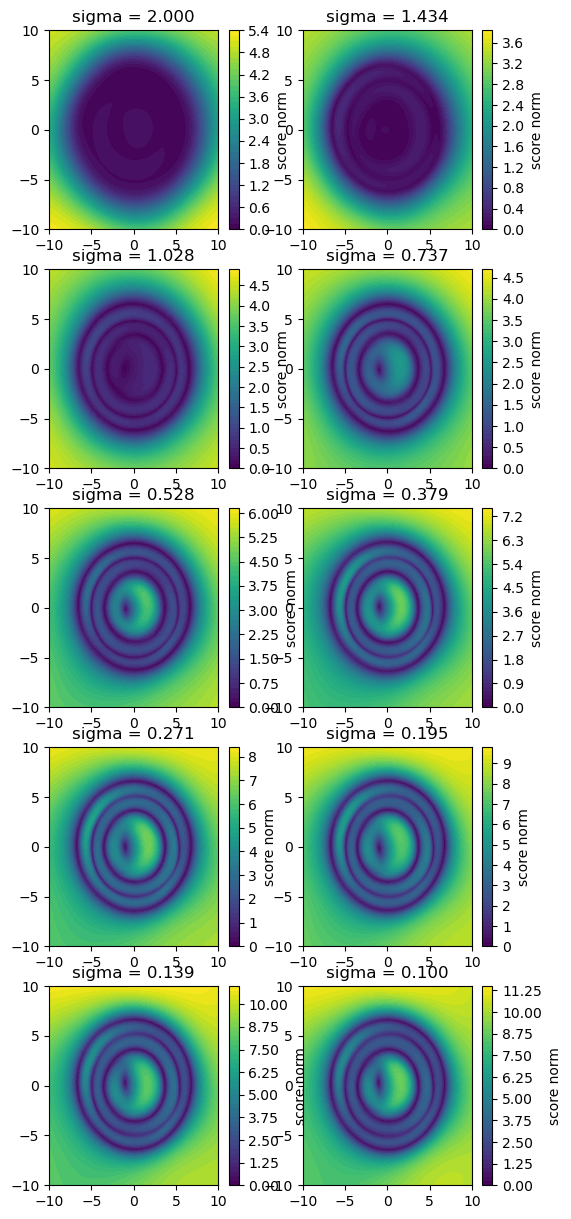

In [51]:
# voir plus précisément que score map (mais perd direction)
ring_mixture = RingMixtureDist(torch.tensor([1.]), torch.tensor([2]), torch.tensor([0.1]))  #ring mixture object

# Generate a finer grid for smoother density visualization
gridsize = 200
grid_lims = 10
x = np.linspace(-grid_lims, grid_lims, gridsize)  # Increased points for smoother plot
y = np.linspace(-grid_lims, grid_lims, gridsize)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

density = ring_mixture.prob_density(positions_tensor)
density = density.numpy().reshape(X.shape)


samples = teacher.sample((1280,))
samples = samples.detach().cpu().numpy()

fig, ax =plt.subplots(int(num_classes//2),2, figsize=(6,6*num_classes/4))
for i in range(num_classes):
  scores_map = score(positions_tensor.detach(), torch.Tensor([i]).int())
  scores_map = scores_map.norm(p=2,dim=-1).detach().numpy().reshape(X.shape)

  im2 = ax[i//2, i%2].contourf(X, Y, scores_map, levels=50, cmap="viridis")
  fig.colorbar(im2, ax=ax[i//2, i%2], label="score norm") # Corrected colorbar placement
  ax[i//2, i%2].set_title(f"sigma = {sigmas[i]:.3f}")


Questions : fine tuning difficile alors que seulement cas 2D. Beaucoup d'hyperparametres à la fois

pour le modèle de score : nb de sigmas, valeurs sigmas, nb_epochs, batch_size

que pour le langevin : lr de départ, iterations par step.... Y a t il une heuristique. Ces derniers ont l'air de dépendre de l'apprentissage

Tester répartition entre les 2 rings

# Plots sympas 1D pour expliquer l'idée du denoising score matching


Avoir une distribution dans un manifold dans un espace 1D revient à avoir des samples distribués en des points. Modélisons les par des gaussiennes à faible variance

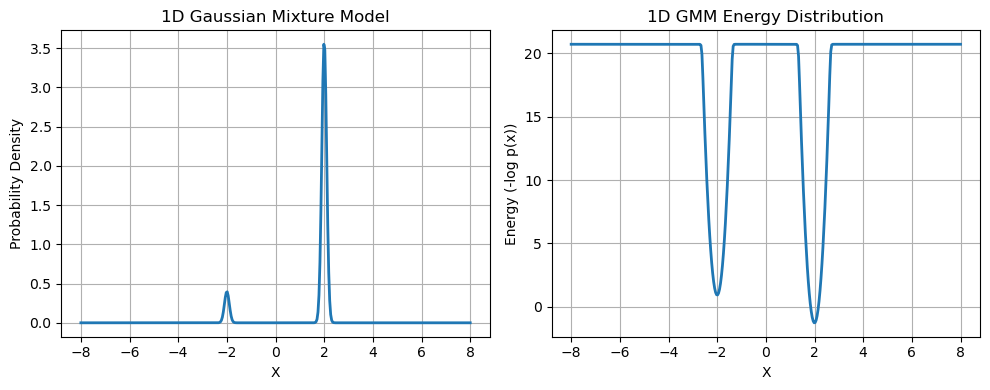

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the two Gaussian distributions
mu1, sigma1 = -2, 0.1
mu2, sigma2 = 2, 0.1
weight1 = 0.1  # Weight for the first Gaussian
weight2 = 1 - weight1  # Weight for the second Gaussian

# Generate x values
x = np.linspace(-8, 8, 400)

# Calculate the Gaussian densities
pdf1 = weight1 * norm.pdf(x, mu1, sigma1)
pdf2 = weight2 * norm.pdf(x, mu2, sigma2)
pdf_mixture = pdf1 + pdf2

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# First subplot (Scatter Plot)
ax[0].plot(x, pdf_mixture, linewidth=2)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Probability Density')
ax[0].set_title('1D Gaussian Mixture Model')
ax[0].grid(True)

# Second subplot (Contour Plot)
ax[1].plot(x, -np.log(pdf_mixture + 1e-9), linewidth=2)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Energy (-log p(x))')
ax[1].set_title('1D GMM Energy Distribution')
ax[1].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

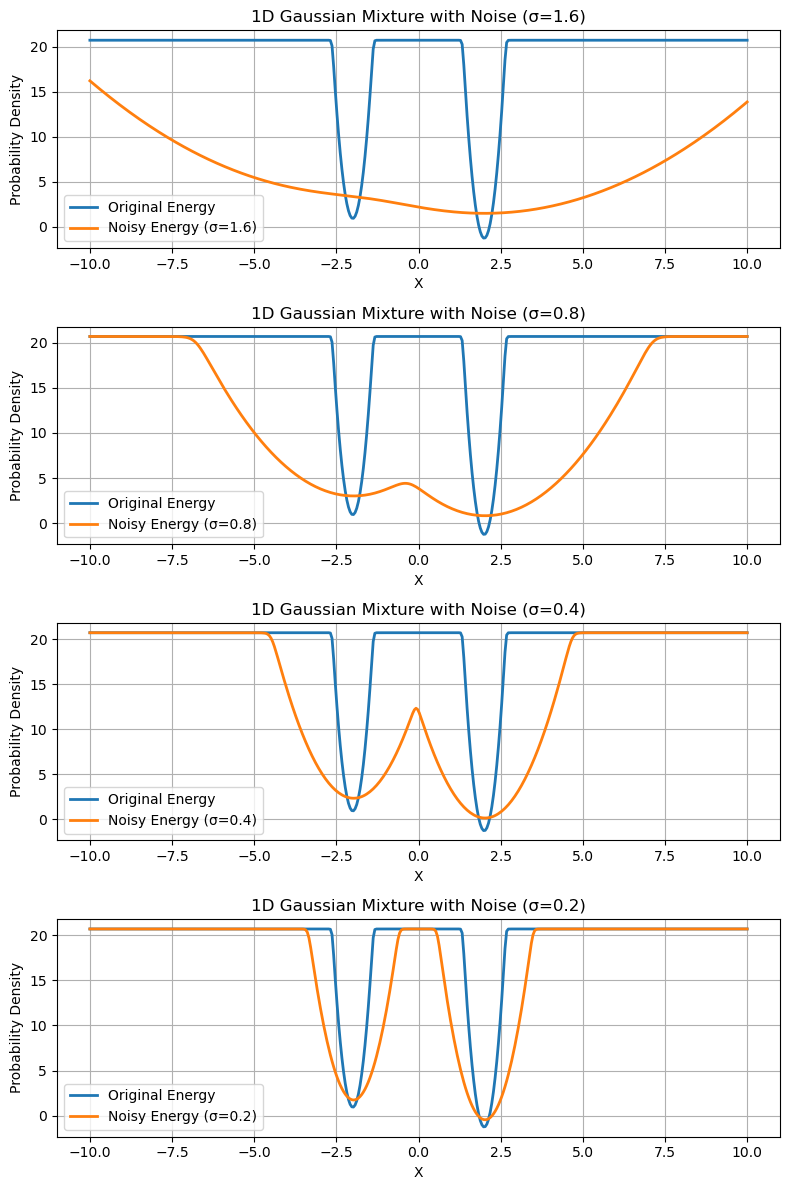

In [53]:
# Noise levels to test
sigmas = [1.6, 0.8, 0.4, 0.2]

# Generate x values
x = np.linspace(-10, 10, 400)
x_bruit = np.linspace(-10, 10, 400)
# Calculate the Gaussian densities
pdf1 = weight1 * norm.pdf(x, mu1, sigma1)
pdf2 = weight2 * norm.pdf(x, mu2, sigma2)
pdf_mixture = pdf1 + pdf2


# Create subplots
fig, axes = plt.subplots(len(sigmas), 1, figsize=(8, 12))

for i, sigma in enumerate(sigmas):
    # Perturb the mixture distribution with Gaussian noise
    noisy_pdf_mixture = np.convolve(pdf_mixture, norm.pdf(x_bruit, 0, sigma), mode='same')
    noisy_pdf_mixture /= np.trapz(noisy_pdf_mixture, x) #renormalize

    # Plot the noisy mixture distribution
    axes[i].plot(x, -np.log(pdf_mixture + 1e-9), label='Original Energy', linewidth=2)
    axes[i].plot(x, -np.log(noisy_pdf_mixture + 1e-9), label=f'Noisy Energy (σ={sigma})', linewidth=2)
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Probability Density')
    axes[i].set_title(f'1D Gaussian Mixture with Noise (σ={sigma})')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

# Plots 2D (plus compliqué car le noyau gaussien utilisé pour les convolutions est rectangulaire et pas circulaire)

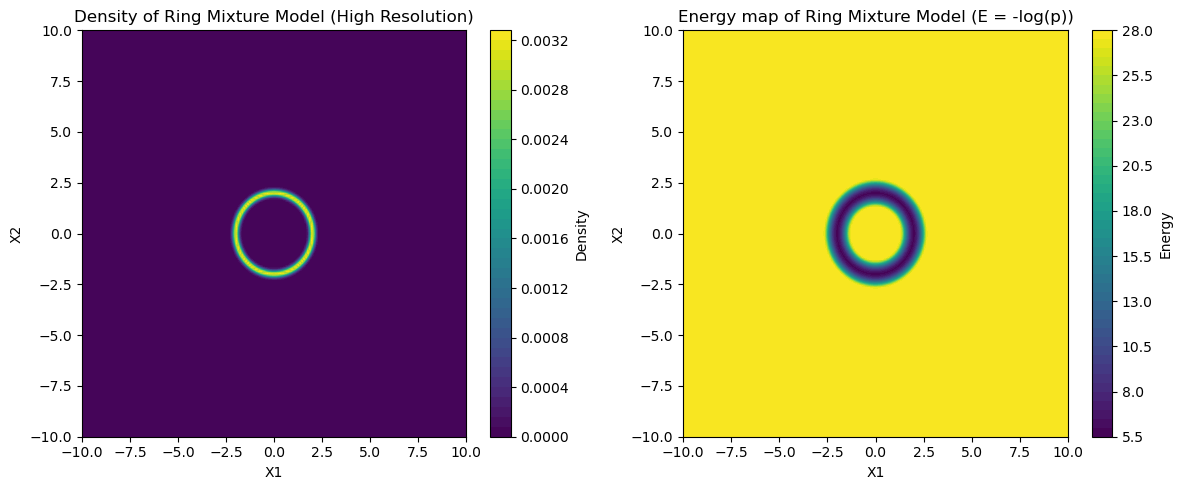

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import torch.autograd as autograd
from scipy.stats import norm

ring_mixture = RingMixtureDist(torch.tensor([1.]), torch.tensor([2]), torch.tensor([0.1]))  #ring mixture object

# Generate a finer grid for smoother density visualization
gridsize = 200
grid_lims = 10
x = np.linspace(-grid_lims, grid_lims, gridsize)  # Increased points for smoother plot
y = np.linspace(-grid_lims, grid_lims, gridsize)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

density = ring_mixture.prob_density(positions_tensor)
density = density.numpy().reshape(X.shape)

energy_map = - ring_mixture.log_prob(positions_tensor)
energy_map = energy_map.numpy().reshape(X.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create a figure and two subplots

# Plot 1: Density
im1 = axes[0].contourf(X, Y, density, levels=50, cmap="viridis")
fig.colorbar(im1, ax=axes[0], label="Density") # Corrected colorbar placement
axes[0].set_title("Density of Ring Mixture Model (High Resolution)")
axes[0].set_xlabel("X1")
axes[0].set_ylabel("X2")

# Plot 2: Energy Map
im2 = axes[1].contourf(X, Y, energy_map, levels=50, cmap="viridis")
fig.colorbar(im2, ax=axes[1], label="Energy") # Corrected colorbar placement
axes[1].set_title("Energy map of Ring Mixture Model (E = -log(p))")
axes[1].set_xlabel("X1")
axes[1].set_ylabel("X2")

plt.tight_layout()
plt.show()

In [55]:
class PerturbedRingMixtureDist(RingMixtureDist):
    def __init__(self, original_dist, noise_std):
        super().__init__(original_dist.pis, original_dist.radiuses, original_dist.spreads)
        self.noise_std = noise_std

    def sampling(self, num_samples):
        samples = super().sampling(num_samples)
        noise = torch.randn_like(samples) * self.noise_std
        return samples + noise

In [56]:
xy_res = 2*grid_lims / gridsize  #in our config same resolution along x and y

def gaussian_kernel(sigma, xy_res):
  kernel_size = 2*int(3*sigma // xy_res) + 1  #to cover most of the distribution
  x_ker = torch.arange(-(kernel_size - 1) // 2, (kernel_size - 1) // 2 + 1) * xy_res
  x_ker = x_ker.repeat(kernel_size).view(kernel_size, kernel_size)
  y_ker = x_ker.t()
  xy_ker = torch.stack([x_ker, y_ker], dim=-1)
  gaussian_kernel = torch.exp(-(x_ker**2 + y_ker**2) / (2*sigma**2))
  gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
  return gaussian_kernel

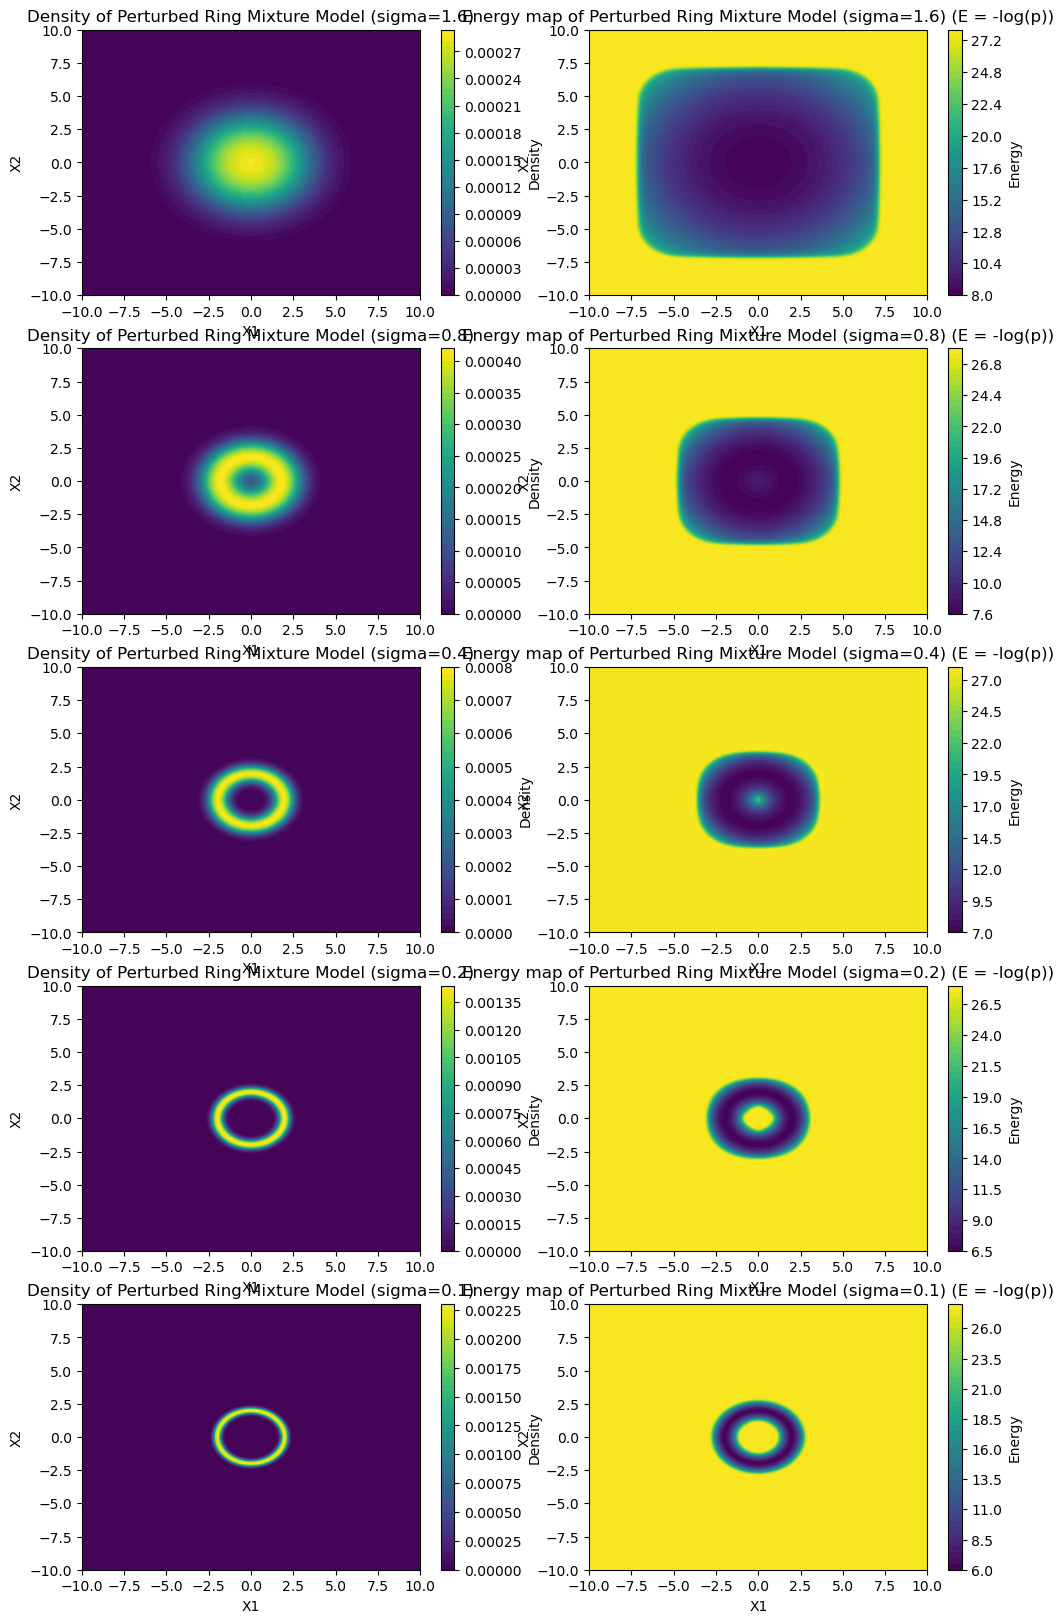

In [57]:
import torch.nn.functional as F

sigmas = [1.6, 0.8, 0.4, 0.2, 0.1]
fig, ax = plt.subplots(len(sigmas), 2, figsize=(12, 4*len(sigmas))) # Create a figure and two subplots

for i, sigma in enumerate(sigmas):
    kernel = gaussian_kernel(sigma, xy_res)
    density_tensor = torch.tensor(density)
    density_blur = F.conv2d(density_tensor.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding='same')
    density_blur = density_blur.squeeze(0).squeeze(0)
    density_blur /= torch.sum(density_blur)


    # Plot 1: Density
    im1 = ax[i,0].contourf(X, Y, density_blur.numpy(), levels=50, cmap="viridis")
    fig.colorbar(im1, ax=ax[i,0], label="Density") # Corrected colorbar placement
    ax[i,0].set_title(f"Density of Perturbed Ring Mixture Model (sigma={sigma})")
    ax[i,0].set_xlabel("X1")
    ax[i,0].set_ylabel("X2")

    # Plot 2: Energy Map
    im2 = ax[i,1].contourf(X, Y, -np.log(density_blur.numpy() + 1e-12), levels=50, cmap="viridis")
    fig.colorbar(im2, ax=ax[i,1], label="Energy") # Corrected colorbar placement
    ax[i,1].set_title(f"Energy map of Perturbed Ring Mixture Model (sigma={sigma}) (E = -log(p))")
    ax[i,1].set_xlabel("X1")
    ax[i,1].set_ylabel("X2")

In [98]:
(np.array(density_blur)[100:,100]).shape

(100,)

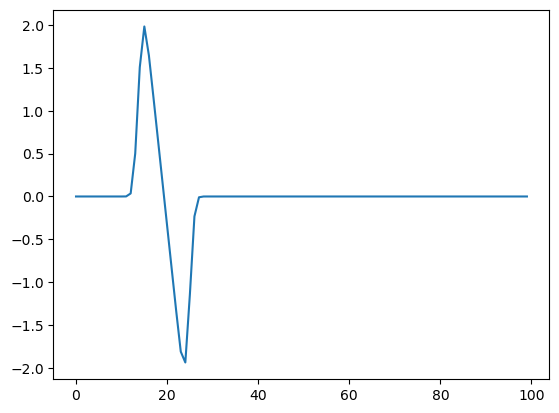

In [106]:
#plot score map using isotropy
gradient_y = np.gradient(np.log(np.array(density_blur)[100:,100] +1e-6))
plt.plot(gradient_y)

def theta(x,y):
  return np.arctan2(y,x)

gradient = np.zeros((density_blur.shape[0], density_blur.shape[1],2))
for i in range(density_blur.shape[0]):
  for j in range(density_blur.shape[1]):
    x, y = X[i,j] , Y[i,j]
    angle = theta(x, y)
    r = np.sqrt(x**2 + y**2)
    if r < 10:
      gradient[i,j,0] =  gradient_y[int(r * 10)] * np.cos(angle)
      gradient[i,j,1] =  gradient_y[int(r * 10)] * np.sin(angle)

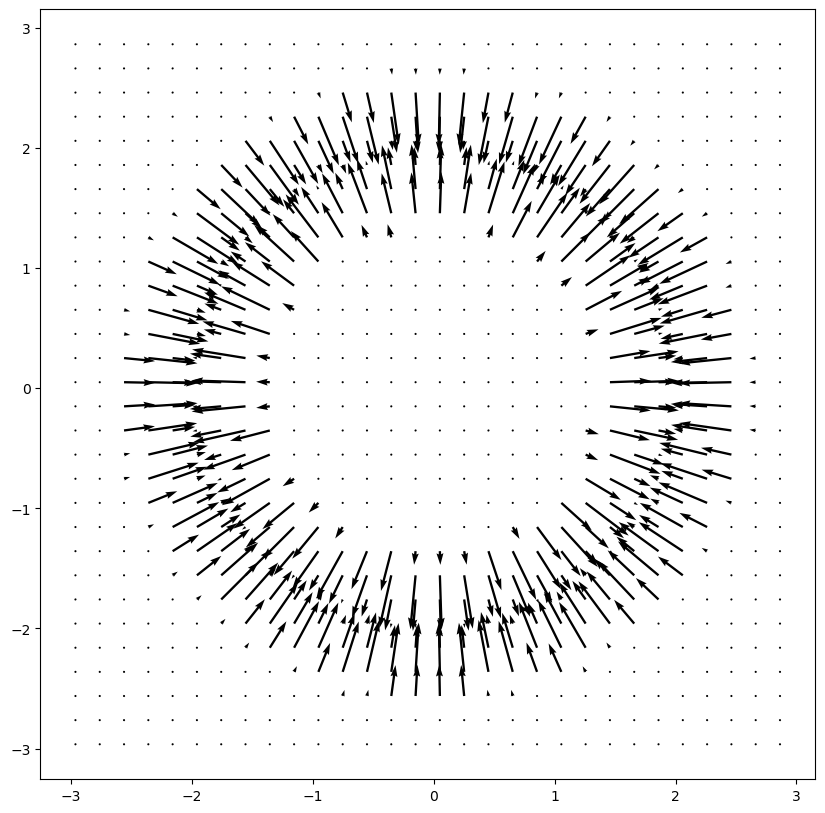

In [121]:
plt.figure(figsize=(10,10))
plt.quiver(X[70:130:2,70:130:2],
            Y[70:130:2,70:130:2], 
            0.1*(gradient[:,:,0][70:130:2,70:130:2] + 1e-6),
            0.1*(gradient[:,:,1][70:130:2,70:130:2] + 1e-6), width=0.003);